In [ ]:
# https://youtu.be/P6sfmUTpUmc
# https://github.com/karpathy/makemore

In [ ]:
# we now want to dig more into neural activity and learning to understand the RNN and LSTM architecture and properties...

import random
import torch
import torch.nn.functional as  F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [ ]:
# read in all the words
random.seed(158)
words=open('nomi_italiani.txt','r').read().splitlines()
random.shuffle(words)
words[0:8]

['argento',
 'giovannino',
 'licurga',
 'elvira',
 'marena',
 'sirio',
 'emilia',
 'bisio']

In [ ]:
len(words)

9105

In [ ]:
# build the vocabulary of characters and mapping to/from integers
chars=sorted(list(set(''.join(words))))

stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos ={i:s for s,i in stoi.items()}
#new
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: '-', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}
28


In [ ]:
# build the dataset

block_size =3 #context length: how many characters do we take to predict the next one ...

def build_dataset(words):
   
    X,Y = [],[]  # input & label

   
    for w in words:
        context=[0]*block_size
        for ch in w +'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
      #  print(''.join(itos[i] for i in context), '--->', itos[ix])
            context=context[1:]+[ix]  # shift: crop and append
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y




In [ ]:
import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([58867, 3]) torch.Size([58867])
torch.Size([7404, 3]) torch.Size([7404])
torch.Size([7372, 3]) torch.Size([7372])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of MLP

g=torch.Generator().manual_seed(123456780)# for reproducibility
C=torch.randn((vocab_size,n_embd), generator=g)
W1=torch.randn((n_embd*block_size,n_hidden), generator=g)
b1=torch.randn(n_hidden, generator=g)
W2=torch.randn((n_hidden,vocab_size), generator=g)
b2=torch.randn(vocab_size, generator=g)
parameters=[C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters))# number of parameter in total...
for p in parameters:
    p.requires_grad = True


12108


In [ ]:
# same optimization as last time
max_steps=200000
batch_size=32
lossi=[]

for i in range(max_steps):
     # mini batch construct
    ix=torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y
        
    # forward bass 
    emb=C[Xb] # embed characters into vectors
    embcat=emb.view(emb.shape[0],-1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h=torch.tanh(hpreact) # hidden layer
    logits= h @ W2 + b2 # output layer
    loss=F.cross_entropy(logits,Yb) #loss function
    
    # backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    
    #update
    lr= 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad
        
    # track stats
    
    if i % 10000 ==0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000:25.2234
  10000/ 200000:2.2866
  20000/ 200000:2.1046
  30000/ 200000:2.1317
  40000/ 200000:1.8162
  50000/ 200000:1.6176
  60000/ 200000:1.8486
  70000/ 200000:1.9469
  80000/ 200000:1.9792
  90000/ 200000:2.3596
 100000/ 200000:1.3009
 110000/ 200000:1.9542
 120000/ 200000:1.5188
 130000/ 200000:1.7100
 140000/ 200000:1.6153
 150000/ 200000:2.0907
 160000/ 200000:1.2940
 170000/ 200000:1.3712
 180000/ 200000:1.7790
 190000/ 200000:1.5750


In [ ]:
# comment that

-torch.tensor(1/28).log()

tensor(3.3322)

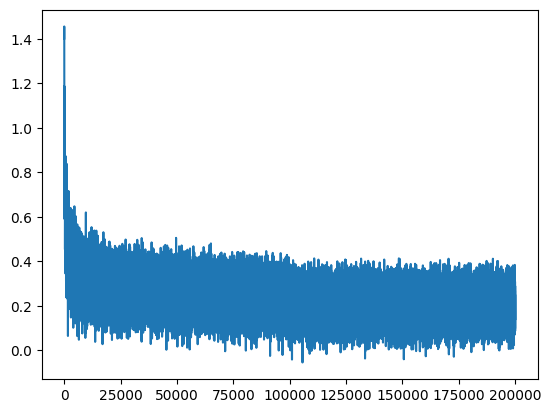

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() #this decorator disables gradient tracking....discuss in class....

def split_loss(split):
    x,y={
        'train':(Xtr,Ytr),
        'val':(Xdev, Ydev),
        'test': (Xte,Yte),
    }[split]
    emb=C[x] #(N,block_size, n_embd)
    embcat=emb.view(emb.shape[0],-1) #concat into (N,block_size*n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h=torch.tanh(hpreact) # hidden layer (N, h_hidden)
    logits= h @ W2 + b2 # output layer (N, vocab_size)
    loss=F.cross_entropy(logits,y) #loss function
    print(split, loss.item())


In [ ]:
split_loss('train')
split_loss('val')

train 1.6465901136398315
val 1.8485839366912842


In [ ]:
# sampling from the model.....

g=torch.Generator().manual_seed(12345678+10)

for _ in range(20):
    out=[]
    context=[0]*block_size
    while True:
        emb=C[torch.tensor([context])] #(1,block_size,n_embed)
        h=torch.tanh(emb.view(1,-1) @ W1 + b1) 
        logits= h @ W2 + b2
        probs=F.softmax(logits,dim=1)
        # sample from the distribuion
        ix=torch.multinomial(probs,num_samples=1,generator=g).item()
        # shift the context window and track the samples
        context=context[1:]+[ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix==0:
            break
        
    print(''.join(itos[i] for i in out)) #decode and print the generated word

albo.
giovanno.
rizio.
siside.
polina.
gio.
assimo.
cecchiarosinda.
benuartinaippirenziana.
peppio.
abdocchia.
bella.
benio.
mohettala.
elino.
erma.
ernella.
filosca.
esaro.
euto.


In [ ]:
#let us focus on the last laeyer ....logits and then softmax 

logits=torch.randn(4)*100
logits=torch.tensor(2,2,2,20)
probs=torch.softmax(logits,dim=0)
loss=-probs[2].log()
print('logits:', logits)
print('probs:',probs)
print('loss:',loss)

TypeError: ignored

In [ ]:
#back to our examples and look at the logit just after the first pass and understand normalization....


# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of MLP

g=torch.Generator().manual_seed(123456780)# for reproducibility
C=torch.randn((vocab_size,n_embd), generator=g)
W1=torch.randn((n_embd*block_size,n_hidden), generator=g)#*0.20         
b1=torch.randn(n_hidden, generator=g)#*0.01
W2=torch.randn((n_hidden,vocab_size), generator=g)#*0.01
b2=torch.randn(vocab_size, generator=g)#*0
parameters=[C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters))# number of parameter in total...
for p in parameters:
    p.requires_grad = True


12108


In [ ]:
# same optimization as last time...try, look at logits then go up and change W2 and b2 normalization.....
max_steps=200000
batch_size=32
lossi=[]

for i in range(max_steps):
     # mini batch construct
    ix=torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y
        
    # forward bass 
    emb=C[Xb] # embed characters into vectors
    embcat=emb.view(emb.shape[0],-1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h=torch.tanh(hpreact) # hidden layer
    logits= h @ W2 + b2 # output layer
    loss=F.cross_entropy(logits,Yb) #loss function
    
    # backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    
    #update
    lr= 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad
        
    # track stats
    
    if i % 10000 ==0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000:25.2234


In [ ]:
logits[1]   #confidently wrong......but with weigth is better....'squashing down the neurons....'

tensor([ 1.7737e-02, -1.2171e-01,  2.3439e-01, -3.4404e-02, -8.2072e-03,
        -1.1706e-03, -3.1911e-02,  6.7048e-02,  7.6216e-02,  1.4230e-02,
         6.3418e-02,  1.2050e-01,  1.3893e-01,  2.5791e-02,  1.4228e-01,
        -8.5727e-02, -1.4190e-01, -1.4446e-01,  1.0751e-01,  4.5441e-02,
         9.7540e-03,  4.0968e-02,  4.4945e-02,  4.4076e-02,  8.1509e-02,
        -5.1188e-02,  5.4436e-05, -4.4057e-02], grad_fn=<SelectBackward>)

In [ ]:
# comment that

-torch.tensor(1/28).log()

tensor(3.3322)

In [ ]:
# Exercise: try the followi ng normalization, train , evaluate and sample the MLP

In [ ]:
# Now we focus on the first layer (show pict): h & hpreact

# remember to intialize and run again 

# look at the +- 1 in h
h

tensor([[-0.0270,  0.8200,  0.5795,  ..., -0.7067,  0.1829, -0.2438],
        [ 0.5184,  0.7766,  0.8988,  ...,  0.1447, -0.1182,  0.9988],
        [ 0.6728,  0.9586,  0.6098,  ..., -0.8293, -0.0165,  0.8832],
        ...,
        [ 0.5977, -0.0139, -0.3177,  ..., -0.7498,  0.0445,  0.8136],
        [-0.0270,  0.8200,  0.5795,  ..., -0.7067,  0.1829, -0.2438],
        [-0.0270,  0.8200,  0.5795,  ..., -0.7067,  0.1829, -0.2438]],
       grad_fn=<TanhBackward>)

In [ ]:
print(len(h.view(-1).tolist()))  #32*200

6400


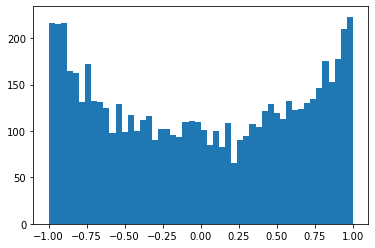

In [ ]:
plt.hist(h.view(-1).tolist(),50) # a lot of neurons  are ' saturated'
plt.show()

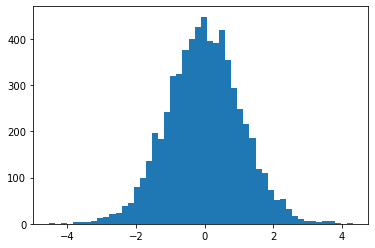

In [ ]:
# now look at the "broad" shape of the 'hpreact' distribution.....and this is bad for learning....we want 'normality' for our brain...
#tgh'(x)= (1-tgh(x)^2).... saturation bring to vanish gradient...no learning...
plt.hist(hpreact.view(-1).tolist(),50) # a lot of neurons  are ' saturated'
plt.show()

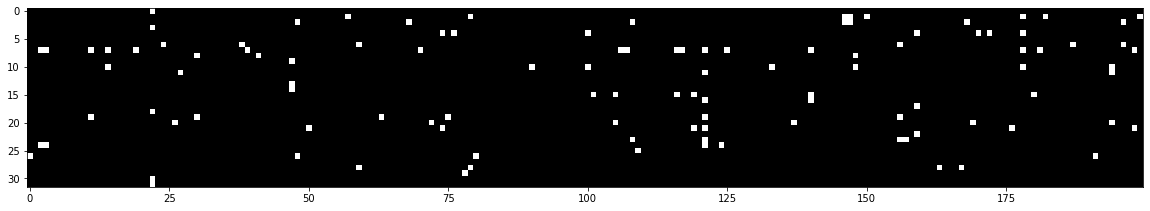

In [ ]:
# looking for dead neurons....comment other Activation Functions..... go back weigth the first layer and try again...

plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

torch.Size([1000, 200])
tensor(0.0031) tensor(1.0027)
tensor(-0.0002) tensor(1.0037)


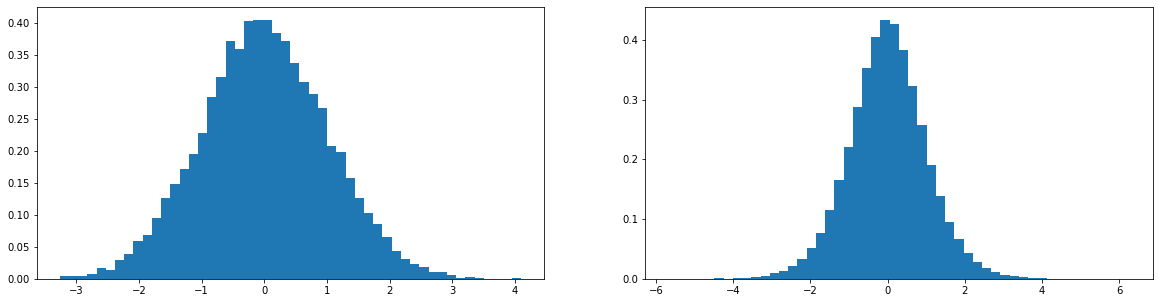

In [ ]:
# why we do not to have to worry too much about inizialization....bach normalization..
# since 2015 
https://arxiv.org/abs/1502.03167
# if the problems are fluctuations and saturations (discuss in class)...then just gaussain normalize at each layer...
# simple as that !!!...and normalizing is differentiable !!....

x=torch.randn(1000,10)
w=torch.randn(10,200)# *.2 #*1/10**0.5
y=x@w
print(y.shape)
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50, density=True);




In [ ]:
# summary from 1:18 after the discussion about batch normalization....